# $\nu$ DoBe event generation
This notebook generates the 3-momentum distributions of both decay electrons in a $^{136}$Xe neutrinoless double beta decay event, according to differnt models for the mLRSM and Leptoquarks. The electron kinematics output of the events is written to an ASCII file, for its further processing within the nexus detector simulation framework.  

### Imports

In [31]:
import sys
sys.path.append("/Users/mistryk2/Packages/nudobe/src/")
sys.path.append("/Users/mistryk2/Packages/nudobe/")

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from nudobe import EFT
from EFT import LEFT

from nudobe import constants, functions
from constants import *

#import neutrino mixing matrix function
from functions import U_PMNS

#import multiprocessing

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D


import matplotlib.cm as cm
import time
import pandas as pd

### Setup mLRSM

In [32]:
def get_masses(m_min           = 0, 
                ordering        = "NO", 
                Majorana_phases = [0,0], 
                v_R             = 10*TeV, 
                v_L             = 0.1*eV, 
                m_heavy         = np.array([10,12,13])*TeV,
                theta_L         = 0,
               ):
    U = U_PMNS(alpha=Majorana_phases)
    m = m_min
    
    if ordering == "NO" or ordering == "NH":
        m1 = m
        m2 = np.sqrt(m1**2+m21)
        m3 = np.sqrt(m2**2+m32)
    elif ordering == "IO" or ordering == "IH":
        m3 = m
        m2 = np.sqrt(m3**2-m32IO)
        m1 = np.sqrt(m2**2-m21)

    
    #diagonal light neutrino masses
    m_nu = np.diag([m1,m2,m3])*1e-9
    
    #diagonal heavy neutrino masses
    m_nu_R = np.diag(m_heavy)
    
    #non-diagonal light neutrino mass
    M_nu = U@m_nu@U.T
    
    #non-diagonal heavy neutrino mass
    M_nu_R = U@m_nu_R@U.T
    
    #inverse matrices
    M_nu_R_inv = np.linalg.inv(M_nu_R)
    
    M_nu_R_dagger_inv = np.linalg.inv(M_nu_R.T.conjugate())
    
    #non-diagonal yukawa matrices
    M_R = M_nu_R.T.conjugate()/(np.sqrt(2)*v_R)
    M_L = M_R.T.conjugate()
    
    M_nu_L = (np.sqrt(2) * v_L * np.exp(1j*theta_L) * M_L)
    
    #get the dirac yukawa matrix eq.57
    M_nu_D = U@m_nu_R@scipy.linalg.sqrtm(v_L/v_R*np.exp(1j*theta_L) * np.diag([1,1,1])
                                                          - np.linalg.inv(m_nu_R)@m_nu+0j)@U.T
    #return results
    return(m_nu, m_nu_R, M_nu_R, M_nu_R_inv, M_nu_R_dagger_inv, M_nu_D, M_nu_L)


# Gets the Wilson Coeficients at SMEFT
def GetWCs_mLRSM(m_min, v_R, v_L, m_heavy, theta_L, xi):
      m_nu, m_nu_R, M_nu_R, M_nu_R_inv, M_nu_R_dagger_inv, M_nu_D, M_nu_L = get_masses(
                                                                                    m_min           = 0, 
                                                                                    ordering        = "NO", 
                                                                                    Majorana_phases = [0,0], 
                                                                                    v_R             = v_R, 
                                                                                    v_L             = v_L, 
                                                                                    m_heavy         = m_heavy,
                                                                                    theta_L         = theta_L,
                                                                                    )


      # SMEFT
      C5         = 1/vev**2 * (M_nu_D.T@M_nu_R_inv@M_nu_D-M_nu_L)[0,0]
      C_LeudPhi7 = np.sqrt(2)/vev * (1/v_R**2 *(V_ud_R.conjugate()) * M_nu_D.T@M_nu_R_inv)[0,0]
      C_LPhiDe7  = 2j * xi*np.exp(1j * alpha) / (1 + xi**2) * C_LeudPhi7 / V_ud_R.conjugate()
      C_eeud9    = 0.88 * (-1 / (2 * v_R**4) * V_ud_R**2 * (M_nu_R_dagger_inv + 2 / m_DR**2 * M_nu_R))[0,0]
      C_eePhiud9 = -4 * (xi * np.exp(-1j * alpha)) / (1 + xi**2) * C_eeud9/V_ud_R
      C_eePhiD9  = 4 * xi**2 * np.exp(-2j * alpha) / ((1 + xi**2)**2) * C_eeud9/V_ud_R**2

      return {"LH(5)"      : C5, 
            "LeudH(7)"   : C_LeudPhi7, 
            "LHDe(7)"    : C_LPhiDe7, 
            "ddueue(9)"  : 4*np.conj(C_eeud9), 
            "deueH2D(9)" : -2 * np.conj(C_eePhiud9), 
            "eeH4D2(9)"  : -np.conj(C_eePhiD9)
            }

# Matches SMEFT wilson coeficients down to m_W scale using Table in Appendix A and Matching scheme in Appendix B
def GetWCsLEFT_mLRSM(m_min, v_R, v_L, m_heavy, theta_L, xi):
      SMEFT_WCs = GetWCs_mLRSM(0, v_R, v_L, m_heavy, theta_L, xi)

      m_bb   = -vev**2 * SMEFT_WCs["LH(5)"]
      C_VR6  = (vev**3/np.sqrt(2)) * SMEFT_WCs["LeudH(7)"].conjugate()
      C_VL6  = - (vev**3 * 1j) /np.sqrt(2) *V_ud * SMEFT_WCs["LHDe(7)"].conjugate()
      C_1R9p = - (vev**5 / 4) *  SMEFT_WCs["ddueue(9)"].conjugate()
      C_4R9  = -vev**5 * (V_ud/2) * SMEFT_WCs["deueH2D(9)"].conjugate()
      C_1R9  = -vev**5 * (V_ud/2) * SMEFT_WCs["eeH4D2(9)"].conjugate()

      return {
            "m_bb"       : m_bb,
            "VR(6)"      : C_VR6,
            "VL(6)"      : C_VL6,
            "1R(9)prime" : C_1R9p,
            "4R(9)"      : C_4R9,
            "1R(9)"      : C_1R9
      }


def get_WCs_leptoquark(alpha_SL  = 0,
            alpha_VL  = 0,
            alpha_SR  = 0,
            alpha_VR  = 0,
            epsilon_S = 0,
            epsilon_V = 0, 
            M_V       = 1*TeV, 
            M_S       = 1*TeV
           ):
    WC_LQ = {}
    
    #see arXiv: hep-ph/9603213 for the definition of eps_I, alpha_I
    WC_LQ["SL(6)"] =  1/(G_F*np.sqrt(2)) * epsilon_V/(M_V**2)
    WC_LQ["SR(6)"] =  1/(G_F*np.sqrt(2)) * epsilon_S/(M_S**2)
    WC_LQ["VL(6)"] = +1/(G_F*np.sqrt(2)) * np.sqrt(2) * (alpha_SL/(M_S**2) + alpha_VL/(M_V**2))
    WC_LQ["VR(6)"] = -1/(G_F*np.sqrt(2)) * (alpha_SR/(M_S**2) + alpha_VR/(M_V**2))

    return(WC_LQ)


In [33]:
#Parameters

# ------- mLRSM ---------
#masses
v_R  = 10*TeV
v_L  = 0.1*eV
m_DR = 4*TeV

#heavy neutrino masses
m_heavy = np.array([10,12,13])*TeV

#mixings
V_ud_R  = V_ud
V_ud_L  = V_ud
xi      = m_b/m_t
theta_L = 0
alpha   = 0

# ------- Leptoquark ---------
# Uses limits based on KamLAND-Zen
M_V       = 1*TeV 
M_S       = 1*TeV
alpha_SL  = 9.75e-9*(M_S/1*TeV)**2
alpha_VL  = 9.75e-9*(M_S/1*TeV)**2
alpha_SR  = 1.77e-6*(M_S/1*TeV)**2
alpha_VR  = 1.77e-6*(M_S/1*TeV)**2
epsilon_S = 3.21e-9*(M_S/1*TeV)**2
epsilon_V = 3.21e-9*(M_V/1*TeV)**2

# Decide if you want to match the SMEFT operators down to LEFT operators
useLEFT = True

# Get the Dark2 colormap
cmap = cm.get_cmap('Dark2')

nbins = 100
eps = 1e-5 #avoid poles
nevts = 1000000

Q = 2.457984 # Q-value in MeV units
me = 0.51099895 # electron mass in MeV units

# NME="SM"
NME="IBM2"
# NME="QRPA"

rho_spec_vec  = []
rho_angle_vec = []

# Define nu_L and xi for each model
Params = []
Params.append({"v_L":0.1*eV, "xi": m_b/m_t})
Params.append({"v_L":0.1*eV, "xi": 0})
Params.append({"v_L":100*eV, "xi": m_b/m_t})
Params.append({"v_L":100*eV, "xi": 0})


Model_Wcs = []

# Add standard Mechanism
for m in range(len(Params)):
      Model_Wcs.append(GetWCs_mLRSM(0, v_R, Params[m]["v_L"], m_heavy, theta_L, Params[m]["xi"]))


if (useLEFT):
      print("Using matching LEFT operators of SMEFT")

Models = []


for m in range(len(Model_Wcs)):
      print(m)

      if (useLEFT):
            Models.append( EFT.LEFT(GetWCsLEFT_mLRSM(0, v_R, Params[m]["v_L"], m_heavy, theta_L, Params[m]["xi"]), name = f"mLRSM {NME} Model {m+1}", method = NME))
      else:
            Models.append(EFT.SMEFT(Model_Wcs[m], name = f"mLRSM {NME} Model {m+1}", method = NME))

# Add the leptoquark model
if (useLEFT):
      Models.append(EFT.LEFT(get_WCs_leptoquark(alpha_SL, alpha_VL, alpha_SR, alpha_VR, epsilon_S, epsilon_V, M_V, M_S), name = f"Leptoquark {NME} Model", method = NME))

# Add standard mechanism to compare to
Models.append(EFT.LEFT({"m_bb" : 28*meV}, name = f"mbb {NME} Model", method = NME))

Using matching LEFT operators of SMEFT
0
1
2
3


In [34]:
# Set the model
model = Models[2]

for WC in model.WC:
    if model.WC[WC] != 0:
        print(WC, model.WC[WC])

model.t_half("136Xe")

m_bb (1.9002780345780945e-12-8.523482826832751e-13j)
VL(6) (-9.019513544211016e-11-2.8871235765782855e-28j)
VR(6) (1.864225321514261e-09+5.967338317544344e-27j)
1R(9) (-5.03710159720303e-11+1.0634491333085474e-12j)
1R(9)prime (4.1925285868643347e-08-8.851401557093658e-10j)
4R(9) (4.492876006261055e-09-9.485504714802962e-11j)
5R(9) (2.2448197885474673e-09-4.739335930588056e-11j)


6.331344035318774e+27

### First, sampling of electron kinetic energies

In [35]:
# Calculate momentum from kinetic energy
def p_fun(t): # valid for both e1 and e2
    p = np.sqrt(t*(t+2.*me))
    return p

In [36]:
# Define normalized energy array
ebar_vec = np.linspace(0+eps, 1-eps, nbins)

# Define array of electron kinetic energies and electron momenta
# ebar = (E_e - m_e)/Q = T_e/Q -> T_e = ebar*Q
t_vec = ebar_vec*Q
#print(t_vec)
p_vec = p_fun(t_vec)

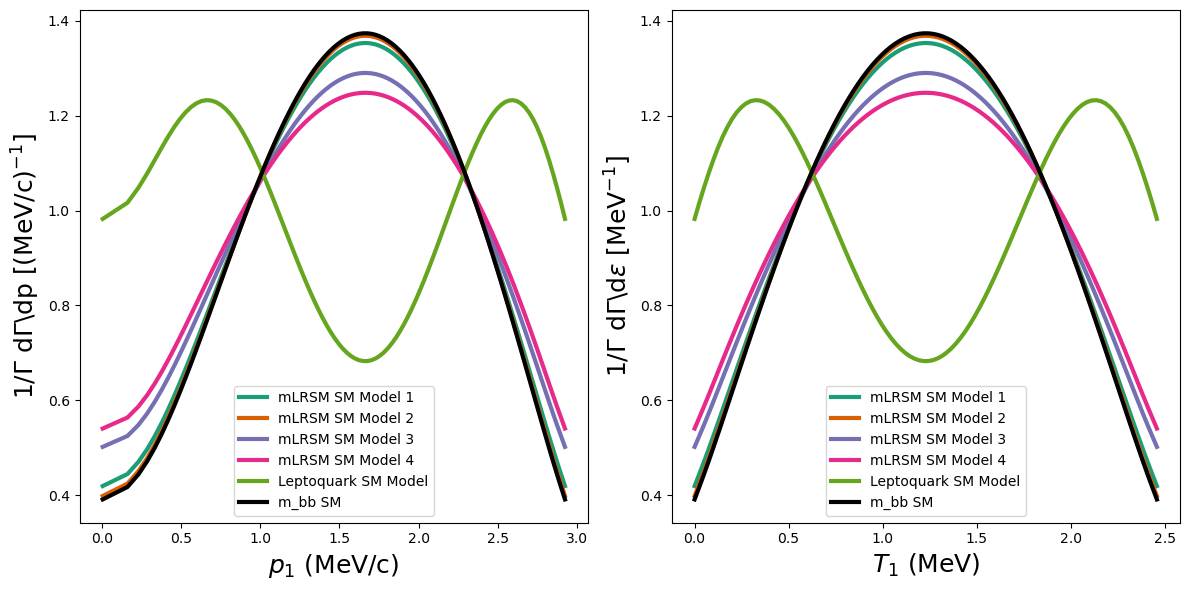

In [37]:
fig = plt.figure(figsize=(12, 6))

colors = [cmap(i) for i in range(5)]
colors.append("k")

for m in range(len(Models)):

    rho_spec_vec.append(Models[m].spectrum(ebar_vec,isotope="136Xe"))

    if (m<len(Model_Wcs)):
        name = f"mLRSM {NME} Model {m+1}"
    
    elif((m==len(Model_Wcs))):
        name = f"Leptoquark {NME} Model"

    else:
        name = f"m_bb {NME}"

    plt.subplot(121)
    plt.plot(p_vec, rho_spec_vec[m]/sum(rho_spec_vec[m])*nbins, linewidth=3,label = name, color = colors[m])
    plt.xlabel(r'$p_1$ (MeV/c)', fontsize=18)
    plt.ylabel("1/$\Gamma$ d$\Gamma$\dp [(MeV/c)$^{-1}$]", fontsize=18)
    plt.legend()

    plt.subplot(122)
    plt.plot(t_vec, rho_spec_vec[m]/sum(rho_spec_vec[m])*nbins, linewidth=3,label = name, color = colors[m])
    plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
    plt.ylabel("1/$\Gamma$ d$\Gamma$\d$\epsilon$ [MeV$^{-1}$]", fontsize=18)
    plt.legend()

    plt.tight_layout()
    

### Second, sampling of electron angular distributions

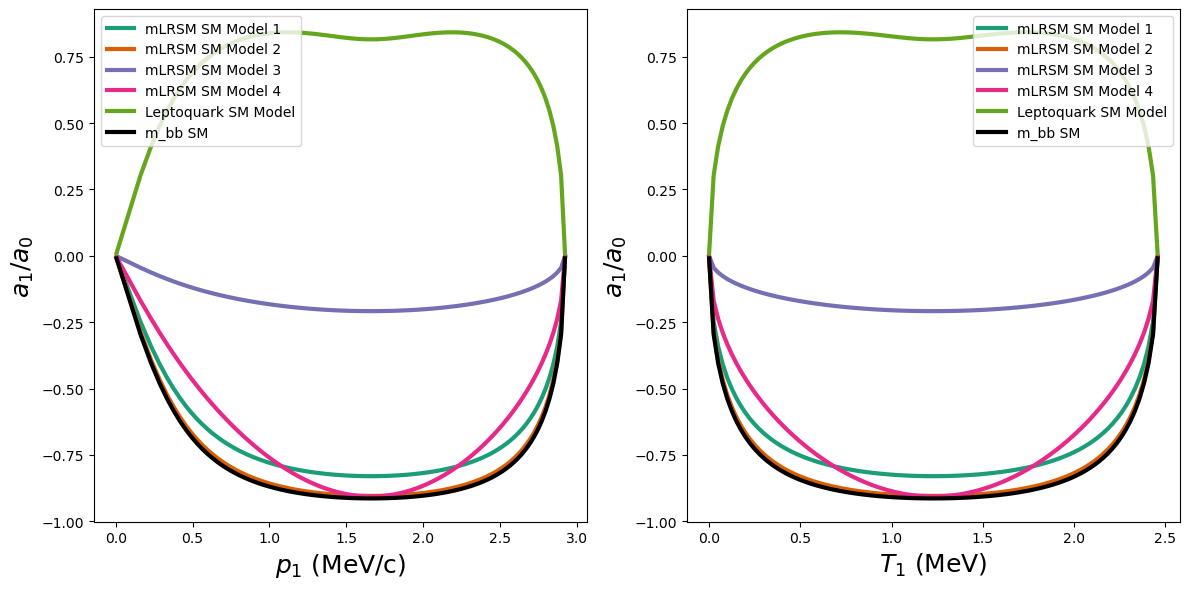

In [38]:
fig = plt.figure(figsize=(12, 6))

for m in range(len(Models)):

    rho_angle_vec.append(Models[m].angular_corr(ebar_vec,isotope="136Xe"))

    if (m<len(Model_Wcs)):
        name = f"mLRSM {NME} Model {m+1}"
    
    elif((m==len(Model_Wcs))):
        name = f"Leptoquark {NME} Model"

    else:
        name = f"m_bb {NME}"

    plt.subplot(121)
    plt.plot(p_vec, rho_angle_vec[m], linewidth=3,label = name, color = colors[m])
    plt.xlabel(r'$p_1$ (MeV/c)', fontsize=18)
    plt.ylabel("$a_1/a_0$", fontsize=18)
    plt.legend()

    plt.subplot(122)
    plt.plot(t_vec, rho_angle_vec[m], linewidth=3,label = name, color = colors[m])
    plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
    plt.ylabel("$a_1/a_0$", fontsize=18)
    plt.legend()

    plt.tight_layout()

### Event Generation

In [39]:
t1_vec = []
t2_vec = []

for m in range(len(Models)):

    # Find maximum, for random generation along y axis for accept-reject method
    rho_spec_max = np.max(rho_spec_vec[m])
    print("rho_spec_max = ", rho_spec_max)

    p_max = p_fun(Q)
    print(p_max)
    t_max = Q
    print(t_max)

    rho_spec_fun = interp1d(t_vec, rho_spec_vec[m], kind='linear', fill_value=(rho_spec_vec[m][0],rho_spec_vec[m][-1]), bounds_error=False)

    t1_vec.append(np.zeros(nevts))
    t2_vec.append(np.zeros(nevts))

    ievt = 0

    while ievt < nevts:

        # Random number from 0 to Q-val
        t1 = np.random.uniform(low = 0., high = t_max)
        p1 = p_fun(t1)
        t2 = Q - t1
        p2 = p_fun(t2)
        
        if (t1 < 0 or t2 < 0 or t1 > t_max or t2 > t_max):
            print(t1,t2)
        
        f = np.random.uniform(low=0., high=rho_spec_max)  
    
        if (f < rho_spec_fun(t1)):
            t1_vec[m][ievt] = t1 # MeV units
            t2_vec[m][ievt] = t2 # MeC units
            ievt += 1
            
    print("# accepted = ", ievt, " over ", nevts)

rho_spec_max =  2.4263624353297027e-29
2.9246777310482606
2.457984
# accepted =  1000000  over  1000000
rho_spec_max =  8.071188838822895e-30
2.9246777310482606
2.457984
# accepted =  1000000  over  1000000
rho_spec_max =  5.149686545258745e-29
2.9246777310482606
2.457984
# accepted =  1000000  over  1000000
rho_spec_max =  8.274975577620253e-30
2.9246777310482606
2.457984
# accepted =  1000000  over  1000000
rho_spec_max =  0.006976699736871315
2.9246777310482606
2.457984
# accepted =  1000000  over  1000000
rho_spec_max =  1.4356014749100583e-27
2.9246777310482606
2.457984
# accepted =  1000000  over  1000000


In [40]:
def cos12_fun(theta1, phi1, theta2, phi2): #cos12 = (p1x*p2x + p1y*p2y + p1z*p2z) / (p1*p2)
    x = np.sin(theta1)*np.cos(phi1) * np.sin(theta2)*np.cos(phi2)
    y = np.sin(theta1)*np.sin(phi1) * np.sin(theta2)*np.sin(phi2)
    z = np.cos(theta1) * np.cos(theta2)
    return x+y+z

In [41]:
def eta_fun(ebar,theta1,phi1,theta2,phi2,rho_angle_fun):
    eta = 1 + rho_angle_fun(ebar)*cos12_fun(theta1,phi1,theta2,phi2)
    return eta

In [42]:
theta1_vec = []
theta2_vec = []
phi1_vec = []
phi2_vec = []
p1_vec = []
p2_vec = []

for m in range(len(Models)):

    rho_angle_fun = interp1d(ebar_vec, rho_angle_vec[m], kind='linear', fill_value=(rho_angle_vec[m][0],rho_angle_vec[m][-1]), bounds_error=False)

    theta1_vec.append(np.zeros(nevts))
    theta2_vec.append(np.zeros(nevts))
    phi1_vec.append(np.zeros(nevts))
    phi2_vec.append(np.zeros(nevts))

    ievt = 0

    # Get vector of p1, p2, beta1 and beta2 values
    p1_vec.append(p_fun(t1_vec[m]))
    p2_vec.append(p_fun(t2_vec[m]))


    while ievt < nevts:
        
        t1 = t1_vec[m][ievt]
        ebar = t1/Q
        # eta_max is for costheta=-1 or costheta=+1, depending on the sign of rho_angle_fun
        eta_max = max(1 - rho_angle_fun(ebar), 1 + rho_angle_fun(ebar))
        #print(ebar,eta_max)
        
        # Note: the cosine of polar angles need to be generated uniformly between -1 and +1. 
        costheta1 = np.random.uniform(low = -1., high = +1.)
        theta1 = np.arccos(costheta1)
        phi1 = np.random.uniform(low = 0., high = 2.*np.pi)
        
        costheta2 = np.random.uniform(low = -1., high = +1.)
        theta2 = np.arccos(costheta2)
        phi2 = np.random.uniform(low = 0., high = 2.*np.pi)
        
        f = np.random.uniform(low=0., high=eta_max) 
    
        if (f < eta_fun(ebar,theta1,phi1,theta2,phi2,rho_angle_fun)):
            theta1_vec[m][ievt] = theta1 
            phi1_vec[m][ievt] = phi1
            theta2_vec[m][ievt] = theta2 
            phi2_vec[m][ievt] = phi2
            ievt += 1
            
    print("# accepted = ", ievt, " over ", nevts)


# accepted =  1000000  over  1000000
# accepted =  1000000  over  1000000
# accepted =  1000000  over  1000000
# accepted =  1000000  over  1000000
# accepted =  1000000  over  1000000
# accepted =  1000000  over  1000000


### Define the momenta components $p_x, p_y, p_z$ of the electrons 

In [43]:
p1x_vec = []
p1y_vec = []
p1z_vec = []
p2x_vec = []
p2y_vec = []
p2z_vec = []

for m in range(len(Models)):
    p1x_vec.append(np.zeros(nevts))
    p1y_vec.append(np.zeros(nevts))
    p1z_vec.append(np.zeros(nevts))

    p2x_vec.append(np.zeros(nevts))
    p2y_vec.append(np.zeros(nevts))
    p2z_vec.append(np.zeros(nevts))


    for ievt in range(nevts):
        p1x_vec[m][ievt] = p1_vec[m][ievt]*np.sin(theta1_vec[m][ievt])*np.cos(phi1_vec[m][ievt])
        p1y_vec[m][ievt] = p1_vec[m][ievt]*np.sin(theta1_vec[m][ievt])*np.sin(phi1_vec[m][ievt]) 
        p1z_vec[m][ievt] = p1_vec[m][ievt]*np.cos(theta1_vec[m][ievt])

        norm1 = np.linalg.norm([p1x_vec[m][ievt],p1y_vec[m][ievt],p1z_vec[m][ievt]])

        p1x_vec[m][ievt] = p1x_vec[m][ievt]/norm1
        p1y_vec[m][ievt] = p1y_vec[m][ievt]/norm1
        p1z_vec[m][ievt] = p1z_vec[m][ievt]/norm1

        
        p2x_vec[m][ievt] = p2_vec[m][ievt]*np.sin(theta2_vec[m][ievt])*np.cos(phi2_vec[m][ievt])
        p2y_vec[m][ievt] = p2_vec[m][ievt]*np.sin(theta2_vec[m][ievt])*np.sin(phi2_vec[m][ievt]) 
        p2z_vec[m][ievt] = p2_vec[m][ievt]*np.cos(theta2_vec[m][ievt])

        norm2 = np.linalg.norm([p2x_vec[m][ievt],p2y_vec[m][ievt],p2z_vec[m][ievt]])

        p2x_vec[m][ievt] = p2x_vec[m][ievt]/norm2
        p2y_vec[m][ievt] = p2y_vec[m][ievt]/norm2
        p2z_vec[m][ievt] = p2z_vec[m][ievt]/norm2


### Save in data file
preparing the output for Geant4

In [44]:
path = "../files/"
outnames = [f"mLRSM_{NME}_M1.txt",f"mLRSM_{NME}_M2.txt",f"mLRSM_{NME}_M3.txt",f"mLRSM_{NME}_M4.txt",f"Leptoquark_{NME}.txt",f"mbb_{NME}.txt"]

for m in range(len(Models)):
    
    # Make a dataframe
    df = pd.DataFrame( {"x1_dir":p1x_vec[m], "y1_dir":p1y_vec[m], "z1_dir":p1z_vec[m], "e1": t1_vec[m], "x2_dir":p2x_vec[m], "y2_dir":p2y_vec[m], "z2_dir":p2z_vec[m], "e2": t2_vec[m]}  )
    df.to_csv(path+outnames[m], index=False, float_format='%.5f')


### Check the distributions

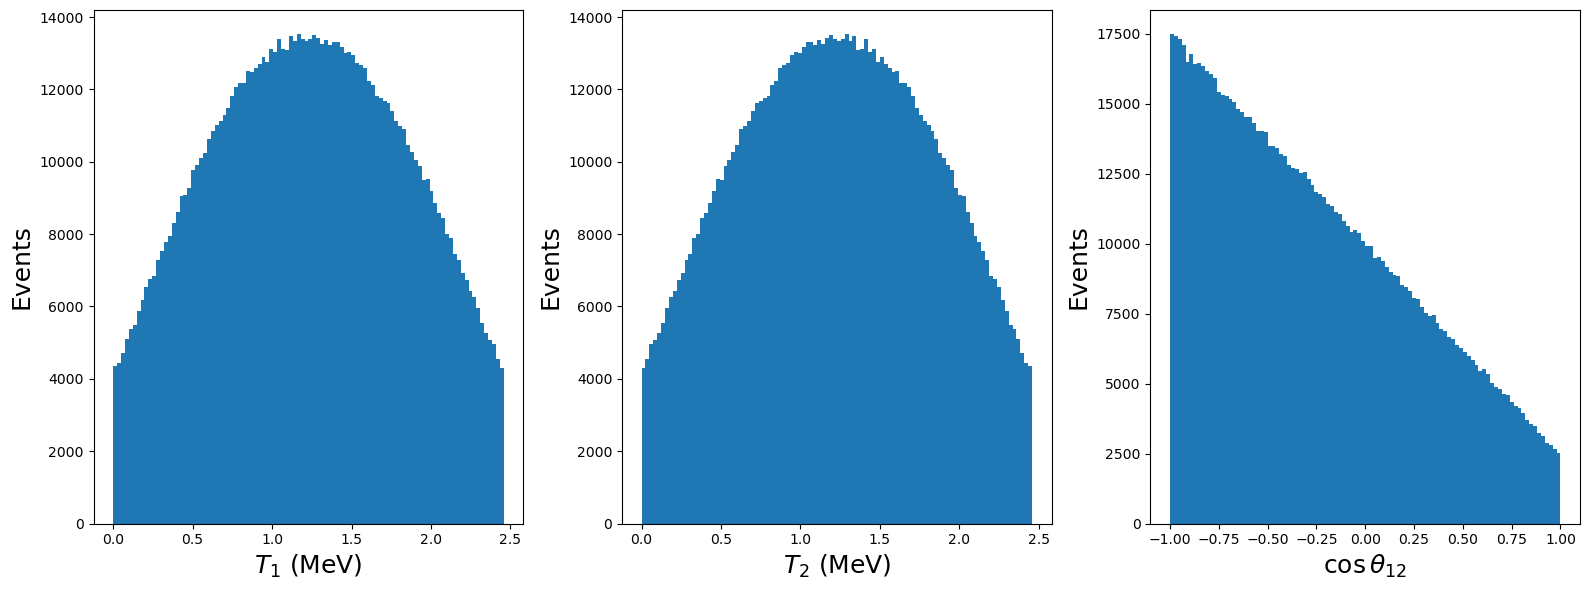

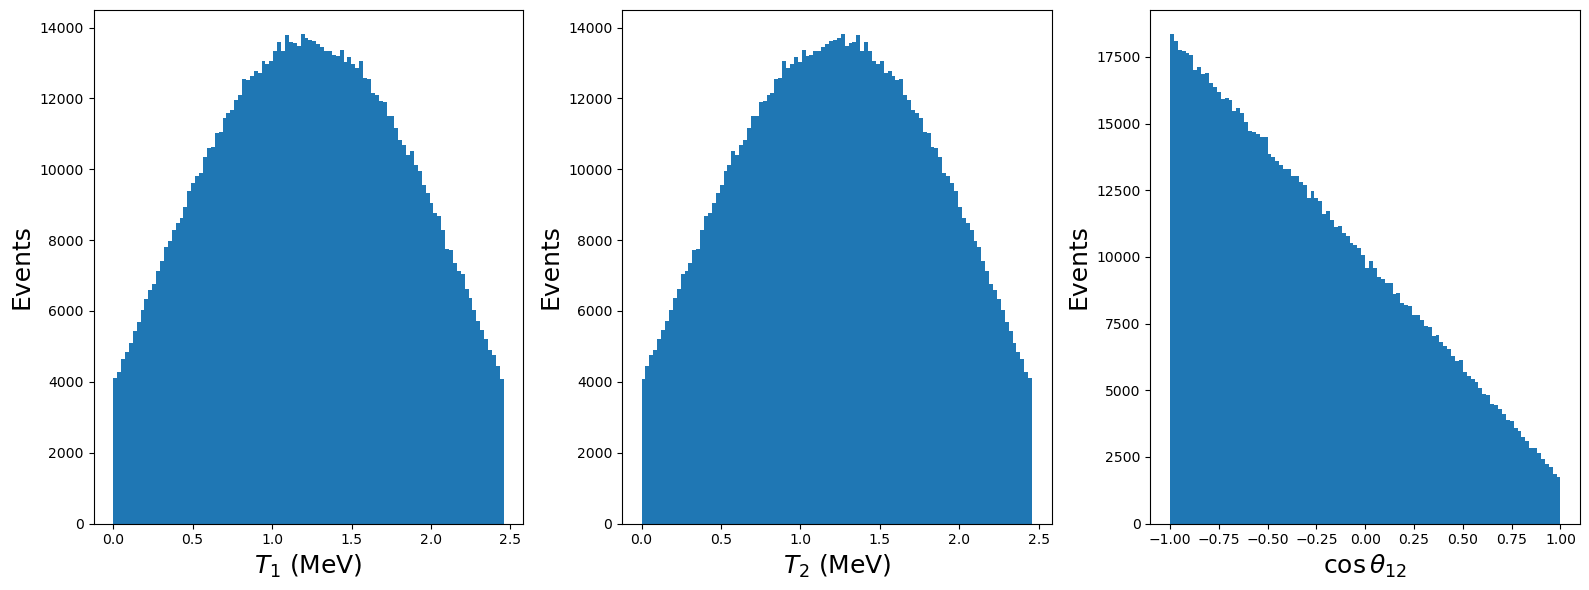

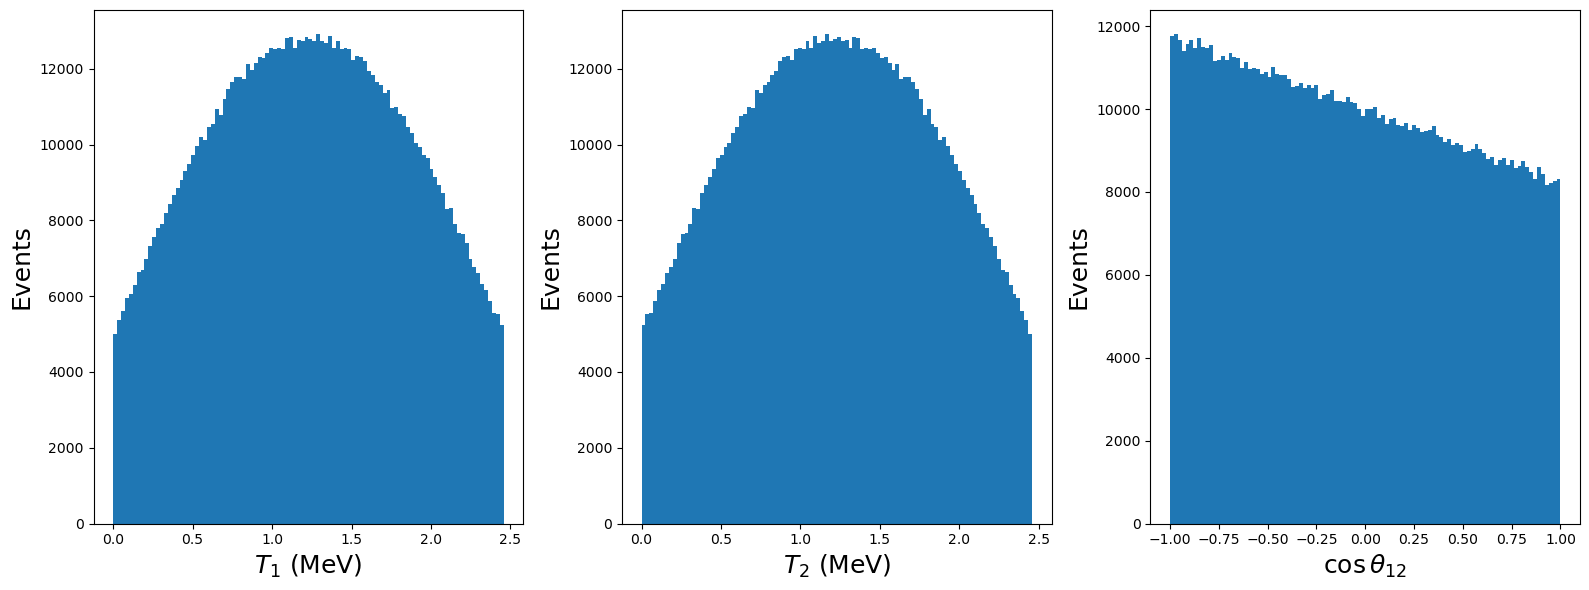

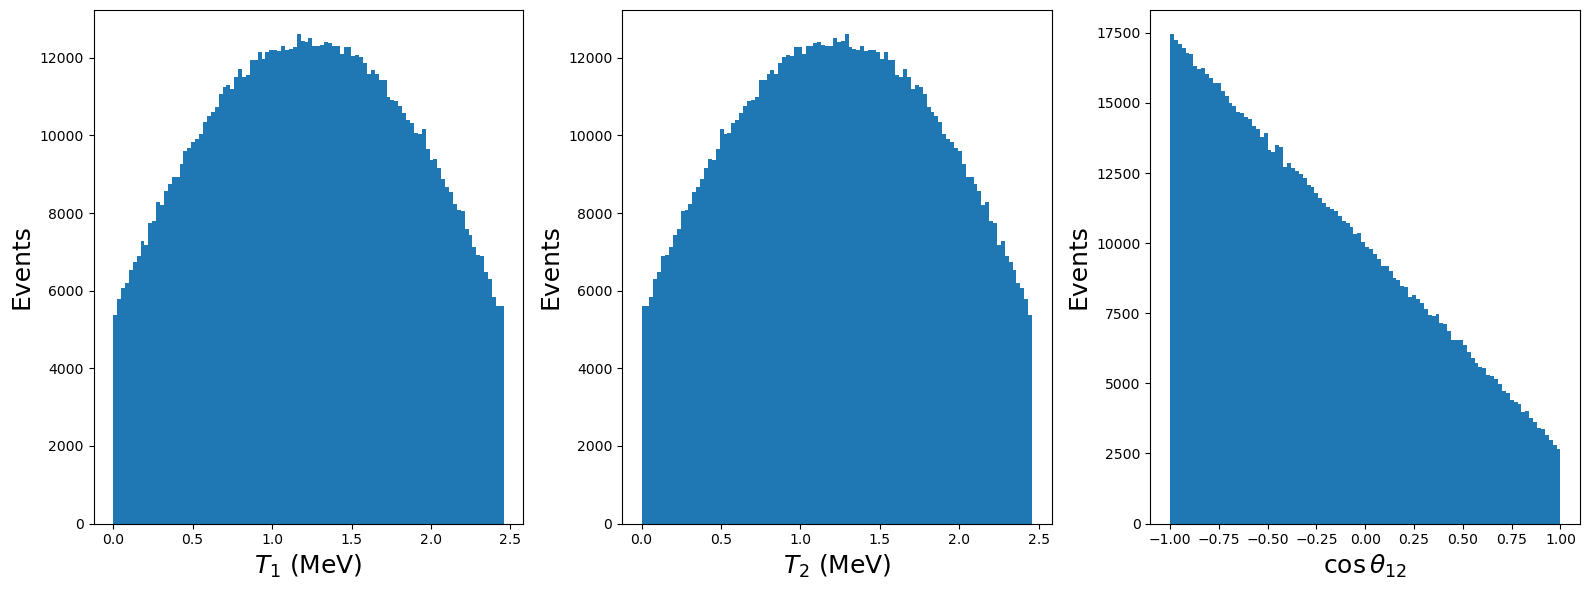

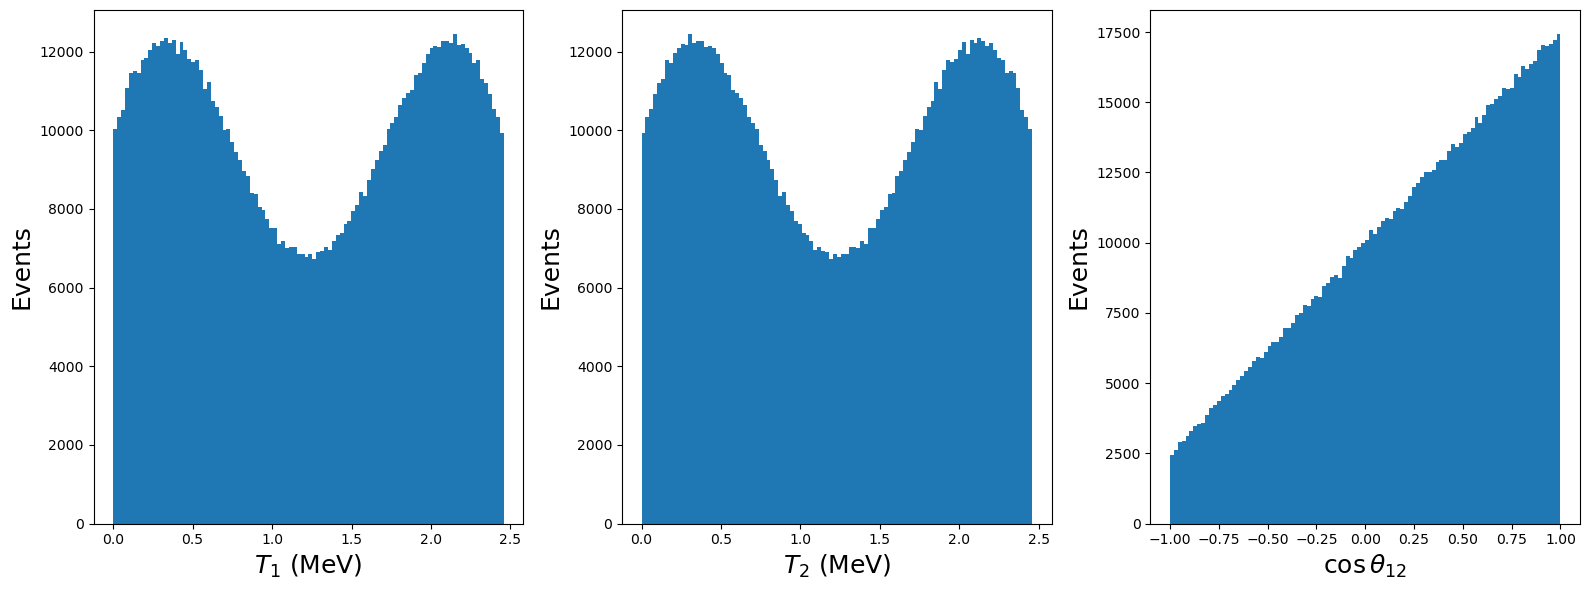

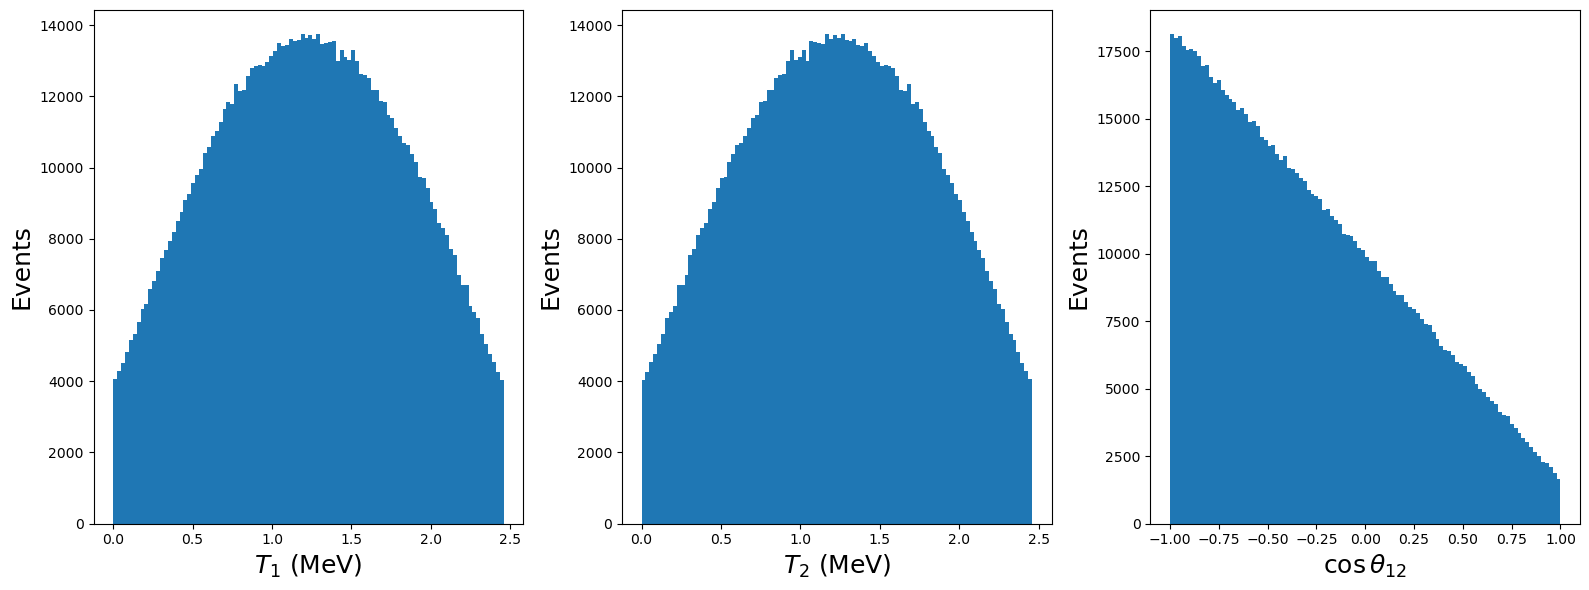

In [49]:
for m in range(len(Models)):

    fig = plt.figure(figsize=(16, 6))

    cos12_vec = cos12_fun(theta1_vec[m], phi1_vec[m], theta2_vec[m], phi2_vec[m])

    plt.subplot(131)
    plt.hist(t1_vec[m], bins=100)
    plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
    plt.ylabel('Events', fontsize=18)

    plt.subplot(132)
    plt.hist(t2_vec[m], bins=100)
    plt.xlabel(r'$T_2$ (MeV)', fontsize=18)
    plt.ylabel('Events', fontsize=18)

    plt.subplot(133)
    counts_costheta12, bins_costheta12, patches = plt.hist(cos12_vec, bins=100)
    plt.xlabel(r'$\cos\theta_{12}$', fontsize=18)
    plt.ylabel('Events', fontsize=18)

    fig.tight_layout()


### Compute dq2 for $T_1$, and Mean and for $\cos\theta_{12}$

In [46]:
def linear_fit(x,a,b):
    return a * (1 + b*x)

In [47]:
def dq2_fun(t1_vec):
    halfQ = Q/2.
    dq2 = 0
    for i in range(len(t1_vec)):
        dq2 += (t1_vec[i]-halfQ)**2
    dq2 = np.sqrt(dq2/len(t1_vec))
    dq2 = dq2/halfQ
    return dq2

In [48]:
dq2_t1 = dq2_fun(t1_vec)
print('dq2 T1:', round(dq2_t1,3))

mean_cos12 = np.mean(cos12_vec)
print('Mean cos12:', round(mean_cos12,3))

xdata = (bins_costheta12[:-1] + bins_costheta12[1:]) / 2
ydata = counts_costheta12
yerrdata = np.power(counts_costheta12, 1/2)
popt, pcov = curve_fit(linear_fit,xdata,ydata,sigma=yerrdata,p0=(1000.,-0.9),absolute_sigma=True,bounds=([0.,-1],[1.e6,1]))
#print(popt[0],popt[1])
#print(pcov)
#print('Slope cos12:', round(popt[1],3))

x_fine = np.linspace(-1,1,num=200)
y_fine = popt[0]*(1+popt[1]*x_fine)
#print(y_fine)

TypeError: type numpy.ndarray doesn't define __round__ method

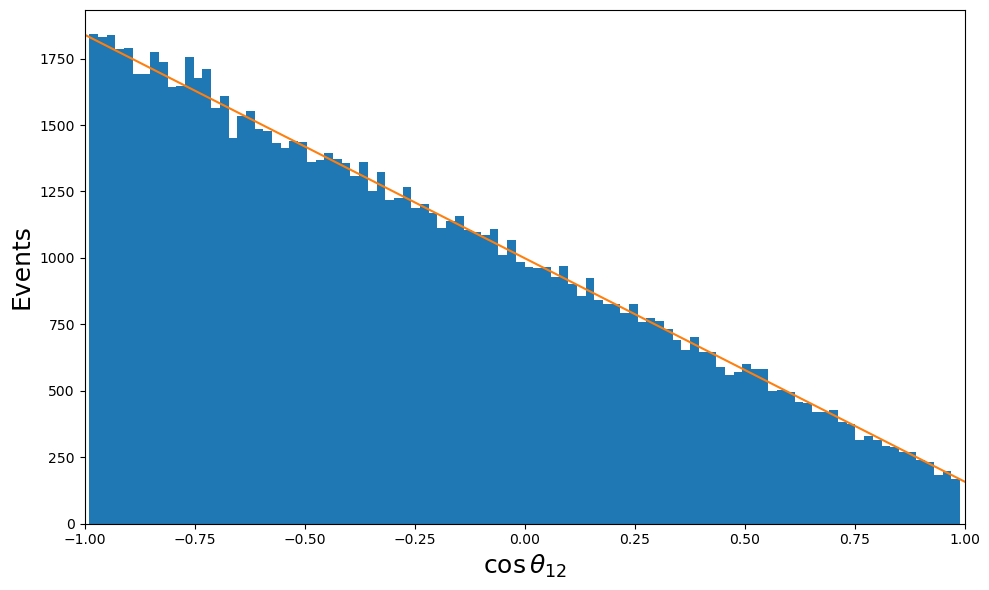

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.hist(xdata,bins=nbins,weights=ydata)
plt.plot(x_fine,y_fine)
plt.xlim(-1.,1.)

plt.xlabel(r'$\cos\theta_{12}$', fontsize=18)
plt.ylabel('Events', fontsize=18)

fig.tight_layout()


### Table summarizing distribution features of various LEFT models

| Model | dq2 of $T_1$ dist. | Mean of $\cos\theta_{12}$ dist. |
| :-: | :-: | :-: |
| m_bb  | 0.492 | -0.283 |
| SL(6) | 0.492 | -0.283 |
| SR(6) | 0.492 | -0.280 | 
| T(6)  | 0.493 | -0.282 | 
| VL(6) | 0.495 | +0.256 | 
| VR(6) | 0.711 | +0.248 |
| VL(7) | 0.492 | -0.282 | 
| VR(7) | 0.491 | -0.282 | 
| 1L(9) | 0.492 | -0.280 | 
| 1R(9) | 0.492 | -0.279 | 
| 1L(9)prime | 0.493 | -0.282 | 
| 1R(9)prime | 0.492 | -0.279 | 
| 2L(9) | 0.491 | -0.281 | 
| 2R(9) | 0.493 | -0.279 | 
| 2L(9)prime | 0.493 | -0.280 | 
| 2R(9)prime | 0.492 | -0.280 | 
| 3L(9) | 0.493 | -0.279 | 
| 3R(9) | 0.492 | -0.284 | 
| 3L(9)prime | 0.491 | -0.282 | 
| 3R(9)prime | 0.493 | -0.283 | 
| 4L(9) | 0.492 | -0.283 | 
| 4R(9) | 0.491 | -0.280 | 
| 5L(9) | 0.493 | -0.283 | 
| 5R(9) | 0.491 | -0.282 | 
| 6(9) | 0.497 | +0.255 | 
| 6(9)prime | 0.495 | +0.251 | 
| 7(9) | 0.496 | +0.257 | 
| 7(9)prime | 0.496 | +0.252 | 
| 8(9) | 0.496 | +0.255 | 
| 8(9)prime | 0.498 | +0.255 | 
| 9(9) | 0.496 | +0.257 | 
| 9(9)prime | 0.497 | +0.252 | 
